In [0]:
import os
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVC

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import precision_recall_curve

_2004 = pd.read_csv('2004.csv')
_2004.drop('Unnamed: 0',axis = 1,inplace = True)

## Metric - Weighted Precision

In [0]:
pre_scorer = make_scorer(precision_score, average = 'weighted')

def weighted_precision(confmat):
    return np.sum(((np.diag(confmat) / np.sum(confmat, axis = 0)) * np.sum(confmat, axis = 1))) / np.sum(confmat)

def weighted_recall(confmat):
    return np.sum(((np.diag(confmat) / np.sum(confmat, axis = 1)) * np.sum(confmat, axis = 1))) / np.sum(confmat)

In [0]:
def report(model,pipeline):
    if not pipeline:
        y_pred = model.predict(X_test_prepared)
    else:
        y_pred = model.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Test weighted macro precision : %.3f' % weighted_precision(confmat))
    print('Test weighted macro recall : %.3f' % weighted_recall(confmat))
    print('Test weighted F1 score : %.3f' % f1_score(y_test, y_pred, average='weighted'))

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()


    

## Preprocessing Pipeline

In [0]:
#preprocessing pipeline
#split train test
X = _2004.drop('Current_Status',axis = 1)
y = _2004.Current_Status

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.1, 
                     stratify=y,
                     random_state=0)

class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self,columns,cleanup_nums): 
        self.columns = columns
        self.cleanup_nums = cleanup_nums
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        X =  X.drop(self.columns,axis=1)
        X = X.replace(self.cleanup_nums)
        return pd.get_dummies(X, drop_first=True)
        

drop_cols = ['Loan_ID','Origination_Date','First_Payment_Date','Zip','Product','Period','Zero_Bal_Cd','Origin_Month','Origin_Year','Seller','State']

#ordinal
cleanup_nums = {"Relocation_Indicator":{"N":0,"Y":1},
                "Mod_Ind":{"N":0,"Y":1},
                "FICO_bins":{"0-620": 0, "620-660": 1, "660-700": 2, "700-740": 3,"740-780": 4, "780+": 5 },
                "Term_bins":{"<= 30 Years": 1, "<=15 Years": 0},
                "Current_Status" : {"Prepaid" : 1, "Current" : 0, "Underperforming" : 2}}

full_pre_pipeline = Pipeline([
        ("preprocess", Preprocess(drop_cols,cleanup_nums)),
        ("scaler", StandardScaler()),
    ])

X_train_prepared = full_pre_pipeline.fit_transform(X_train)
X_test_prepared = full_pre_pipeline.transform(X_test)

p = Preprocess(drop_cols,cleanup_nums)
cols_for_importance = p.fit_transform(X_train).columns

## Fine Tuning dtree

best params : {'max_depth': 5}
best score : 0.9497656801450376
CV for dtree: 0.949 +/- 0.002
--------------------------------Test-------------------------------------------
Test weighted macro precision : 0.954
Test weighted macro recall : 0.962
Test weighted F1 score : 0.949


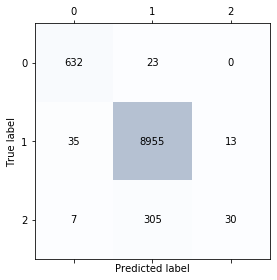

In [120]:
gs_dtree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring=pre_scorer,
                  cv=5,refit = True)

gs_dtree.fit(X_train_prepared, y_train)
print('best params : {}'.format(gs_dtree.best_params_))
print('best score : {}'.format(gs_dtree.best_score_))

scores = cross_val_score(gs_dtree, X_train_prepared, y_train, 
                         scoring=pre_scorer, cv=5)


print('CV for dtree: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

print('--------------------------------Test-------------------------------------------')
report(gs_dtree, False)

## Feature Selection Pipeline
To Reduce the Computation time.

Test weighted macro precision : 0.954
Test weighted macro recall : 0.962
Test weighted F1 score : 0.949


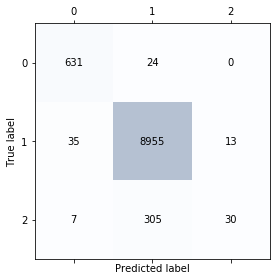

In [126]:
pipe_dtree_selected = Pipeline([('full_preprocess' , full_pre_pipeline),
          ('selected_features',SelectFromModel(DecisionTreeClassifier(**gs_dtree.best_params_,random_state = 0),
                                                                    threshold=-np.inf,max_features = 10)),
          ('decision_tree', DecisionTreeClassifier(**gs_dtree.best_params_,random_state = 0))
                                      ])

pipe_dtree_selected.fit(X_train,y_train)

report(pipe_dtree_selected, True)

## Grid Search For Number Of Features

best params : {'selected_features__max_features': 3}
best score : 0.9521066078511454
--------------------------------Test-------------------------------------------
Test weighted macro precision : 0.953
Test weighted macro recall : 0.961
Test weighted F1 score : 0.949


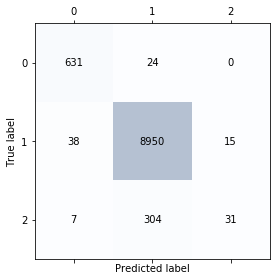

In [127]:
param_grid = [{
    'selected_features__max_features': list(range(1, len(cols_for_importance) + 1))
}]

gs_features_dtree = GridSearchCV(pipe_dtree_selected, param_grid, cv=5,
                                scoring=pre_scorer)

gs_features_dtree.fit(X_train, y_train)
print('best params : {}'.format(gs_features_dtree.best_params_))
print('best score : {}'.format(gs_features_dtree.best_score_))

print('--------------------------------Test-------------------------------------------')
report(gs_features_dtree, True)

## Fine Tune Random Forests

Test weighted macro precision : 0.952
Test weighted macro recall : 0.961
Test weighted F1 score : 0.949


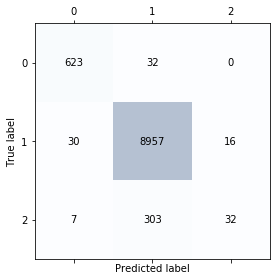

In [112]:
gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                  param_grid= {'n_estimators': [10,100,300],'max_features' : ['auto', 'sqrt']},
                  scoring=pre_scorer,
                  cv=5,refit = True)

gs_rf.fit(X_train_prepared, y_train)
print('best params : {}'.format(gs_rf.best_params_))
print('best score : {}'.format(gs_rf.best_score_))
print('--------------------------------Test-------------------------------------------')
report(gs_rf, False)

rf = gs_rf.best_estimator_
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train_prepared.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_for_importance[indices[f]], 
                            importances[indices[f]]))

## Feature Selection

Test weighted macro precision : 0.952
Test weighted macro recall : 0.962
Test weighted F1 score : 0.951


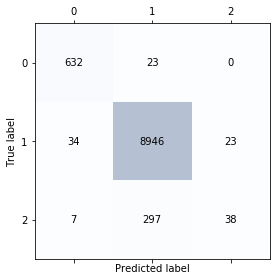

In [7]:
pipe_rf_selected = Pipeline([('full_preprocess' , full_pre_pipeline),
          ('selected_features',SelectFromModel(RandomForestClassifier(**gs_rf.best_params_,random_state = 0),
                                                                    threshold=-np.inf,max_features = 10)),
          ('random_forest', RandomForestClassifier(**gs_rf.best_params_,random_state = 0))
                                      ])

pipe_rf_selected.fit(X_train,y_train)

report(pipe_rf_selected, True)

## Grid Search For Number Of Features

best params : {'selected_features__max_features': 3}
best score : 0.9575914383110075
--------------------------------Test-------------------------------------------
Test weighted macro precision : 0.960
Test weighted macro recall : 0.966
Test weighted F1 score : 0.958


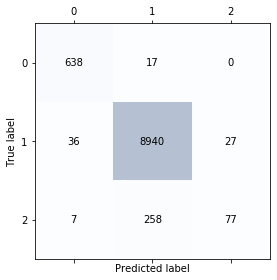

In [63]:
param_grid = [{
    'selected_features__max_features': list(range(1, len(cols_for_importance) + 1))
}]

gs_features = GridSearchCV(pipe_rf_selected, param_grid, cv=5,
                                scoring=pre_scorer)

gs_features.fit(X_train, y_train)
print('best params : {}'.format(gs_features.best_params_))
print('best score : {}'.format(gs_features.best_score_))

print('--------------------------------Test-------------------------------------------')
report(gs_features, True)

## Over Sampling And Under Sampling
To improve the perfomance of minority classes

In [115]:
over2 = SMOTE(sampling_strategy={'Current' : 40000, 'Underperforming' : 40000})
X_over, y_over = over2.fit_resample(X_train_prepared,y_train)

from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')

X_over, y_over = under.fit_resample(X_over,y_over)
X_over.shape

(120000, 31)

Test weighted macro precision : 0.949
Test weighted macro recall : 0.945
Test weighted F1 score : 0.946


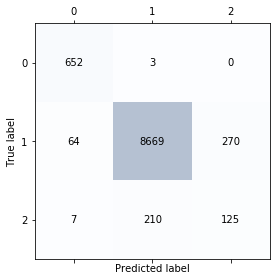

In [59]:
rf_sampling = RandomForestClassifier(**gs_rf.best_params_)
rf_sampling.fit(X_over, y_over)

report(rf_sampling, False)

best params : {'n_estimators': 300}
best score : 0.9727646845441049
--------------------------------Test-------------------------------------------
Test weighted macro precision : 0.949
Test weighted macro recall : 0.945
Test weighted F1 score : 0.947


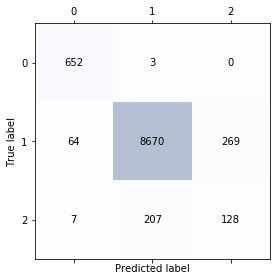

 1) Age                            0.511218
 2) FICO_bins                      0.067735
 3) Current_UPB                    0.066154
 4) Borrower_FICO                  0.043909
 5) UPB                            0.038317
 6) Current_IR                     0.035759
 7) Interest_Rate                  0.035265
 8) LTV                            0.030866
 9) CLTV                           0.029803
10) DTI                            0.026950
11) Num_Borrowers                  0.020535
12) Mod_Ind                        0.017593
13) Loan_Term                      0.012629
14) Insurance%                     0.009818
15) Loan_Purpose_P                 0.007485
16) Term_bins                      0.007296
17) Channel_R                      0.006454
18) Channel_C                      0.006072
19) Dwelling_Type_SF               0.004799
20) Loan_Purpose_R                 0.004307
21) Mortgage_Insurance_Type        0.003750
22) Occupancy_P                    0.002982
23) First_Time_Buyer_Y          

In [62]:
gs_rf_sampling = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                  param_grid= {'n_estimators': [10,100,300,400]},
                  scoring=pre_scorer,
                  cv=5,refit = True)

gs_rf_sampling.fit(X_over, y_over)
print('best params : {}'.format(gs_rf_sampling.best_params_))
print('best score : {}'.format(gs_rf_sampling.best_score_))
print('--------------------------------Test-------------------------------------------')
report(gs_rf_sampling, False)

importances = gs_rf_sampling.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_over.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            cols_for_importance[indices[f]], 
                            importances[indices[f]]))

Test weighted macro precision : 0.944
Test weighted macro recall : 0.938
Test weighted F1 score : 0.940


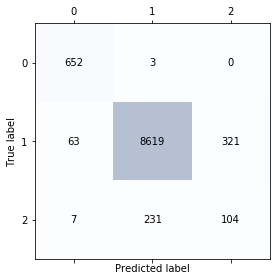

In [61]:
pipe_rf_selected_sampling = Pipeline([
          ('selected_features',SelectFromModel(RandomForestClassifier(**gs_rf_sampling.best_params_,random_state = 0),
                                                                    threshold=-np.inf,max_features = 11)),
          ('random_forest', RandomForestClassifier(**gs_rf_sampling.best_params_,random_state = 0))
          ])

pipe_rf_selected_sampling.fit(X_over,y_over)

report(pipe_rf_selected_sampling, False)

In [0]:
param_grid = [{
    'selected_features__max_features': list(range(1, len(cols_for_importance) + 1))
}]

gs_features_sampling = GridSearchCV(pipe_rf_selected_sampling, param_grid, cv=5,
                                scoring=pre_scorer)

gs_features_sampling.fit(X_train, y_train)
print('best params : {}'.format(gs_features_sampling.best_params_))
print('best score : {}'.format(gs_features_sampling.best_score_))

print('--------------------------------Test-------------------------------------------')
report(gs_features_sampling, True)